# Basic Autoencoder

## Imports and definitions

In [15]:
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm_notebook
import torch

### Model Class and Loss Function Definitions

In [ ]:
class VAE(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super().__init__()

        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        input_layer = self.relu(self.fc1(x))
        hidden_layer = self.relu(self.fc2(input_layer))
        return hidden_layer

    def decode(self, z):
        hidden_layer = self.relu(self.fc3(z))
        output_layer = self.sigmoid(self.fc4(hidden_layer))
        return output_layer

    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        x_prime = self.decode(z)
        return x_prime

In [ ]:
def loss_fn(x_prime, x):
    return F.binary_cross_entropy(x_prime, x.view(-1, 784),
            size_average=False)

### Training and Testing Functions

In [ ]:
def train(model, data_loader, optimizer, loss_fn=loss_fn, loss_alpha=0.05, prev_loss=0.0):
    model.train()
    training_loss = prev_loss
    
    tqdm_iterator = tqdm_notebook(data_loader)
    for data, _ in tqdm_iterator:
        x = Variable(data).cuda()
        
        optimizer.zero_grad()
        x_prime = model(x)
        
        loss = loss_fn(x_prime, x)
        loss.backward()
        
        training_loss = ((loss_alpha * loss.data[0] / len(x)) +
                          (1.0 - loss_alpha) * training_loss)
        tqdm_iterator.set_postfix(loss=f'{training_loss:0.4f}')
        optimizer.step()
    return training_loss

def test(model, data_loader, optimizer, loss_fn=loss_fn):
    model.eval()
    test_loss = 0
    
    for data, _ in data_loader:
        x = Variable(data).cuda()
        x_prime = model(x)
        test_loss += loss_fn(x_prime, x).data[0]
        
    test_loss /= len(test_loader.dataset)
    return test_loss

### Plotting and Utility Functions

In [10]:
def to_np(v):
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    return v.cpu().numpy()

def plot_input_output_pairs(model, data_loader, title,
        num_cols=10, figsize=(15, 3.2)):
    x = (iter(data_loader).next()[0])
    x_prime = model(Variable(x).cuda())

    x_formatted = to_np(x)
    x_prime_formatted = to_np(x_prime).reshape(x.shape[0], x.shape[-2], x.shape[-1])

    f = plt.figure(figsize=figsize)
    f.suptitle(title, fontsize=20)
    
    for i in range(num_cols):
        ax = f.add_subplot(2, num_cols, i+1)
        ax.imshow(x_formatted[i][0], cmap='gray')
        if i == 0:
            ax.set_ylabel('Input')
        else:
            ax.axis('off')

        ax = f.add_subplot(2, num_cols, num_cols+i+1)
        ax.imshow(x_prime_formatted[i], cmap='gray')
        if i == 0:
            ax.set_ylabel('Output')
        else:
            ax.axis('off')
    return f

## Datasets and Loaders

In [11]:
# if you want deterministic results...
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [12]:
kwargs = {
    'batch_size': 512,
    'num_workers': 1,
    'pin_memory': True,
    'shuffle': True
}

mnist_dataset = datasets.MNIST('data/mnist',
    train=True, download=True, transform=transforms.ToTensor())
training_loader = DataLoader(mnist_dataset, **kwargs)
    
mnist_test_dataset = datasets.MNIST('data/mnist',
    train=False, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test_dataset, **kwargs)

In [17]:
HIDDEN_SIZE = 4096
LATENT_SIZE = 4
NUM_EPOCHS = 50

model = VAE(hidden_size=HIDDEN_SIZE, latent_size=LATENT_SIZE)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

training_loss = 0.0
for epoch_num in range(1, NUM_EPOCHS + 1):
    training_loss = train(model, training_loader, optimizer, prev_loss=training_loss)
    test_loss = test(model, test_loader, optimizer)
    
    print(f'Epoch {epoch_num} -- training loss: {training_loss:0.4f}  '
          f'test loss: {test_loss:0.4f}')

HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 1 -- training loss: 153.9010  test loss: 151.0041


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 2 -- training loss: 144.5768  test loss: 143.5449


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 3 -- training loss: 138.6344  test loss: 139.7603


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 4 -- training loss: 136.1910  test loss: 136.5930


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 5 -- training loss: 134.0406  test loss: 135.1529


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 6 -- training loss: 132.7560  test loss: 133.9434


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 7 -- training loss: 132.3969  test loss: 134.1586


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 8 -- training loss: 131.0563  test loss: 132.2637


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 9 -- training loss: 130.0959  test loss: 131.5451


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 10 -- training loss: 129.5093  test loss: 130.7670


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 11 -- training loss: 128.0799  test loss: 130.2509


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 12 -- training loss: 128.5001  test loss: 130.1558


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 13 -- training loss: 127.8319  test loss: 129.7499


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 14 -- training loss: 127.0740  test loss: 129.5134


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 15 -- training loss: 126.4135  test loss: 128.9873


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 16 -- training loss: 126.5600  test loss: 129.0783


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 17 -- training loss: 125.3551  test loss: 128.2651


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 18 -- training loss: 125.0612  test loss: 128.1707


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 19 -- training loss: 124.8760  test loss: 128.0196


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 20 -- training loss: 124.5140  test loss: 127.7318


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 21 -- training loss: 123.6975  test loss: 127.2889


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 22 -- training loss: 123.6355  test loss: 127.7692


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 23 -- training loss: 122.9036  test loss: 126.8584


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 24 -- training loss: 123.1417  test loss: 127.7335


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 25 -- training loss: 122.4979  test loss: 126.8627


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 26 -- training loss: 122.2616  test loss: 126.8178


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 27 -- training loss: 121.7317  test loss: 126.5680


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 28 -- training loss: 121.5958  test loss: 126.0812


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 29 -- training loss: 121.1267  test loss: 126.2478


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 30 -- training loss: 121.7547  test loss: 126.4782


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 31 -- training loss: 121.6987  test loss: 126.3106


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 32 -- training loss: 121.0122  test loss: 126.0564


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 33 -- training loss: 121.5108  test loss: 125.7029


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 34 -- training loss: 120.5190  test loss: 125.8680


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 35 -- training loss: 120.3658  test loss: 126.4422


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 36 -- training loss: 120.0350  test loss: 125.5992


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 37 -- training loss: 120.1561  test loss: 125.6117


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 38 -- training loss: 119.4172  test loss: 126.0463


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 39 -- training loss: 119.6210  test loss: 125.4897


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 40 -- training loss: 119.4369  test loss: 125.7096


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 41 -- training loss: 120.0659  test loss: 125.7846


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 42 -- training loss: 119.5199  test loss: 125.6465


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 43 -- training loss: 119.0581  test loss: 125.3702


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 44 -- training loss: 118.6588  test loss: 125.7312


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 45 -- training loss: 118.5417  test loss: 125.6972


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 46 -- training loss: 118.5086  test loss: 125.4500


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 47 -- training loss: 118.1538  test loss: 125.5332


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 48 -- training loss: 118.8267  test loss: 125.4021


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 49 -- training loss: 117.6599  test loss: 125.7215


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


Epoch 50 -- training loss: 117.7133  test loss: 125.5273


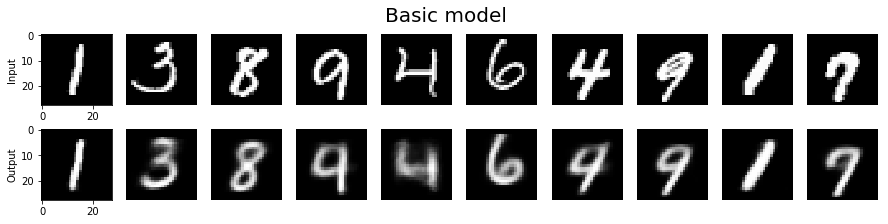

In [18]:
plot_input_output_pairs(model, training_loader, "Basic model");

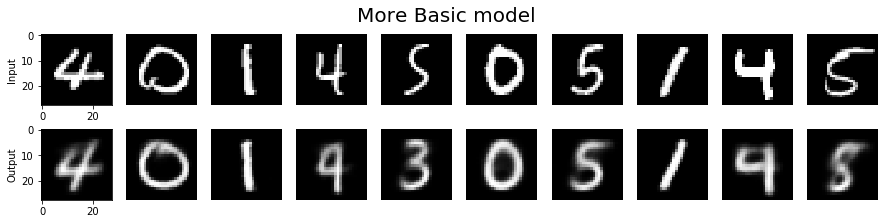

In [19]:
plot_input_output_pairs(model, training_loader, "More Basic model");

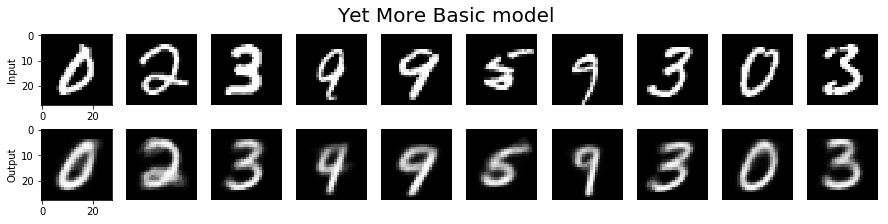

In [20]:
plot_input_output_pairs(model, training_loader, "Yet More Basic model");